In [1]:
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
html_text = requests.get('http://www.nuforc.org/webreports/ndxlTX.html').text
soup = BeautifulSoup(html_text, 'html5lib')
headers = soup.find('tr')
col_names = []
for hdr in headers.find_all('th'):
  col_names.append(hdr.text)

csv_file = open('ufos_in_texas.csv','w')

csv_writer = csv.writer(csv_file)
csv_writer.writerow(col_names)

for row_item in soup.find('tbody').find_all('tr'):
  row_values = []
  for row in row_item.find_all('td'):
    row_values.append(row.text)
  csv_writer.writerow(row_values)

csv_file.close()

In [3]:
df = pd.read_csv('ufos_in_texas.csv')
test = df.head()
num_rows_original = df.shape[0]
df.head()

,Date / Time,City,State,Country,Shape,Duration,Summary,Posted
0,2/27/22 17:15,San Antonio,TX,USA,Diamond,less than a minute,Trapezoid/Diamond/Kite shaped mirrored object ...,3/4/22
1,2/24/22 19:31,Hondo,TX,USA,Other,4 minutes,Objects in the sky with multiple activity goin...,3/4/22
2,2/23/22 21:00,El Paso,TX,USA,Light,30,A bright white light that streaked across the ...,3/4/22
3,2/21/22 23:39,Harlingen,TX,USA,Light,short 1 second,Short burst of green and blueish light,3/4/22
4,2/18/22 06:45,Silsbee,TX,USA,Disk,20-30 minutes,It was so bright. It was daylight but it was l...,3/4/22


In [4]:
df = df[df['Duration'].str.fullmatch('\d+\s(second|minute|hour|day)s?') == True]
#df.to_csv('filtered_df.csv', index=False)
df.head()

,Date / Time,City,State,Country,Shape,Duration,Summary,Posted
1,2/24/22 19:31,Hondo,TX,USA,Other,4 minutes,Objects in the sky with multiple activity goin...,3/4/22
5,2/14/22 02:13,Arlington,TX,USA,Light,10 seconds,Bright light(bright like the North Star) Dropp...,3/4/22
11,2/1/22 19:00,Mount Pleasant,TX,USA,Sphere,3 minutes,We step outside and looked up. It was like a s...,3/4/22
12,1/29/22 00:06,San Antonio,TX,USA,Star,7 seconds,Beautiful LARGE white-tailed shooting star,3/4/22
17,1/2/22 06:43,Lake Jackson,TX,USA,Fireball,5 seconds,It’s filed on iPhone off flat screen over Tetons,3/4/22


In [5]:
# filter out invalid durations
# convert all valid durations to seconds

df['Duration'].replace('( minute)s?', '*60 seconds', regex=True, inplace=True)
df['Duration'].replace('( hour)s?', '*3600 seconds', regex=True, inplace=True)
df['Duration'].replace('( day)s?', '*86400 seconds', regex=True, inplace=True)
df['Duration'].replace('( second)s?', '*1', regex=True, inplace=True)


inter_m=df['Duration'].str.split("*",expand=True)
inter_m[0] = pd.to_numeric(inter_m[0], errors='coerce')
inter_m[1] = pd.to_numeric(inter_m[1], errors='coerce')

df['Duration']=inter_m[0] * inter_m[1]

df.to_csv('final.csv', index=False)
num_rows_filtered = df.shape[0]
df.head()


,Date / Time,City,State,Country,Shape,Duration,Summary,Posted
1,2/24/22 19:31,Hondo,TX,USA,Other,240,Objects in the sky with multiple activity goin...,3/4/22
5,2/14/22 02:13,Arlington,TX,USA,Light,10,Bright light(bright like the North Star) Dropp...,3/4/22
11,2/1/22 19:00,Mount Pleasant,TX,USA,Sphere,180,We step outside and looked up. It was like a s...,3/4/22
12,1/29/22 00:06,San Antonio,TX,USA,Star,7,Beautiful LARGE white-tailed shooting star,3/4/22
17,1/2/22 06:43,Lake Jackson,TX,USA,Fireball,5,It’s filed on iPhone off flat screen over Tetons,3/4/22


In [6]:
print("Total #rows in original dataset : {}".format(num_rows_original))
print("Total #rows in new 'validated' dataset : {}".format(num_rows_filtered))

Total #rows in original dataset : 5667
Total #rows in new 'validated' dataset : 2828


Max duration in the validated dataset : 345600
Min duration in the validated dataset : 1
Mean duration in the validated dataset : 1288.9285714285713
Std Deviation of  duration in the validated dataset : 10830.138895073518


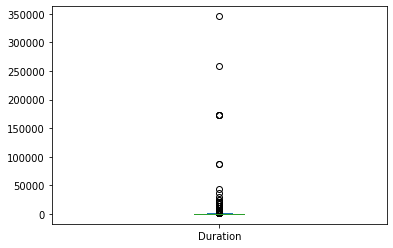

In [7]:
# basic statistics of duration in 'validated' dataset
print("Max duration in the validated dataset : {}".format(df['Duration'].max()))
print("Min duration in the validated dataset : {}".format(df['Duration'].min()))
print("Mean duration in the validated dataset : {}".format(df['Duration'].mean()))
print("Std Deviation of  duration in the validated dataset : {}".format(df['Duration'].std()))

# boxplot
df['Duration'].plot(kind='box',showfliers=True) #with outliers 

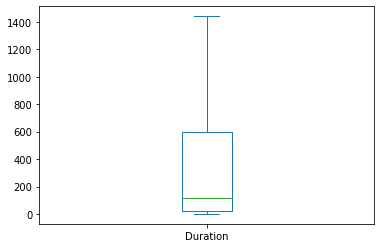

In [8]:
df['Duration'].plot(kind='box',showfliers=False) #with outliers

In [9]:
# clean data 
import re
df = pd.read_csv('ufos_in_texas.csv')
test = df.head()
num_rows_original = df.shape[0]

#drop the rows which are empty
df.dropna(subset=['Duration'],inplace=True)

df['Duration'] = df['Duration'].str.replace(r'(<|>|~|\+|\.)s?', '', regex=True, case=False) #removing <,>,~

# processing elements like 3-4 minutes 
for index,row in df.iterrows():

  row['Duration']=str(row['Duration']) #converting to string type
  row['Duration'] = row['Duration'].lstrip()
  row['Duration'] = row['Duration'].rstrip()

  #removing characters present after x-y seconds as some have '.' or some additional text after the time unit
  if(re.match('\d+[-]?\d+?\s+(sec|second|min|minute|hr|hour|day|year)s?.*',row['Duration'],flags=re.IGNORECASE) != None):
    split_data = row['Duration'].split(" ") 
    row['Duration'] = split_data[0] + ' ' + split_data[1]

  #taking the mid point of the time range (example: 3-4 minutes => 3.5 minutes)
  if(re.match('\d+[-]\d+\s+(sec|second|min|minute|hr|hour|day|year)s?.*',row['Duration'],flags=re.IGNORECASE) != None):
    split_data = row['Duration'].split(" ")
    unit = split_data[1].split('.')[0]
    split_data = split_data[0].split("-")
    row['Duration'] = (float(split_data[0]) + float(split_data[1]))/2
    row['Duration'] = str(row['Duration']) + ' ' + unit
    
#handling the spelling errors and shorthands
df['Duration'] = df['Duration'].str.replace(r'\bsecs?\s?\b', 'seconds', regex=True, case=False) #replacing sec,secs with seconds
df['Duration'] = df['Duration'].str.replace(r'\bsecondss\b', 'seconds', regex=True, case=False) #replacing secondss with seconds 
df['Duration'] = df['Duration'].str.replace(r'\bmins?\s?\b', 'minutes', regex=True, case=False) #replacing min,mins with minutes
df['Duration'] = df['Duration'].str.replace(r'\bminutess\b', 'minutes', regex=True, case=False) #replacing minutess with minutes 
df['Duration'] = df['Duration'].str.replace(r'\bhrs?\b', 'hours', regex=True, case=False) #replacing hr/hrs with hours 

#filtering out the rows that don't have the data in the expected format
df = df[df['Duration'].str.fullmatch('\d+(\.\d+)?\s(second|minute|hour|day|year)s?', case=False) == True]

#converting all values to seconds
df['Duration'].replace('( minute)s?', '*60 seconds', regex=True, inplace=True)
df['Duration'].replace('( hour)s?', '*3600 seconds', regex=True, inplace=True)
df['Duration'].replace('( day)s?', '*86400 seconds', regex=True, inplace=True)
df['Duration'].replace('( year)s?', '*31536000 seconds', regex=True, inplace=True)
df['Duration'].replace('( second)s?', '*1', regex=True, inplace=True)

inter_m=df['Duration'].str.split("*",expand=True)
inter_m[0] = pd.to_numeric(inter_m[0], errors='coerce')
inter_m[1] = pd.to_numeric(inter_m[1], errors='coerce')

df['Duration']=inter_m[0] * inter_m[1]

# saving the cleaned data in a csv
df.to_csv('cleaned_seconds.csv', index=False)
num_rows_filtered = df.shape[0]
print(df.shape)
df.head()



(4234, 8)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date / Time,City,State,Country,Shape,Duration,Summary,Posted
1,2/24/22 19:31,Hondo,TX,USA,Other,240.0,Objects in the sky with multiple activity goin...,3/4/22
4,2/18/22 06:45,Silsbee,TX,USA,Disk,1500.0,It was so bright. It was daylight but it was l...,3/4/22
5,2/14/22 02:13,Arlington,TX,USA,Light,10.0,Bright light(bright like the North Star) Dropp...,3/4/22
11,2/1/22 19:00,Mount Pleasant,TX,USA,Sphere,180.0,We step outside and looked up. It was like a s...,3/4/22
12,1/29/22 00:06,San Antonio,TX,USA,Star,7.0,Beautiful LARGE white-tailed shooting star,3/4/22


In [10]:
# total rows in original dataset
print("Total #rows in original dataset : {}".format(num_rows_original))

# valid rows in your cleaned dataset
print("Total #rows in new 'validated' dataset : {}".format(df.shape[0]))

Total #rows in original dataset : 5667
Total #rows in new 'validated' dataset : 4234


Max duration in the validated dataset : 157680000.0
Min duration in the validated dataset : 1.0
Mean duration in the validated dataset : 40508.72707155151
Std Deviation of  duration in the validated dataset : 2472580.5753309303


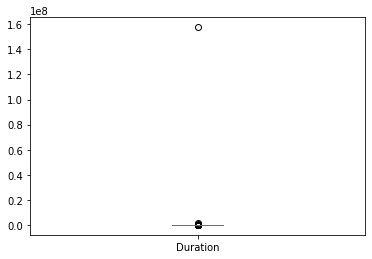

In [11]:
print("Max duration in the validated dataset : {}".format(df['Duration'].max()))
print("Min duration in the validated dataset : {}".format(df['Duration'].min()))
print("Mean duration in the validated dataset : {}".format(df['Duration'].mean()))
print("Std Deviation of  duration in the validated dataset : {}".format(df['Duration'].std()))

# draw a boxplot for your cleaned dataset
df['Duration'].plot(kind='box',showfliers=True) #with outliers 

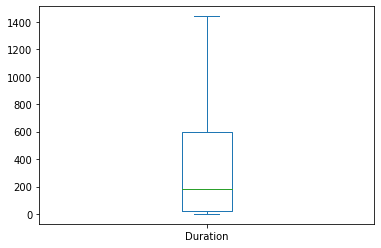

In [12]:
df['Duration'].plot(kind='box',showfliers=False) #without outliers 

Observations:

There are some outliers in the data which are very high values. After removing outliers, the range of values is around 1400 seconds(~24mins).
From the boxplots in 1b and 1c(ignoring outliers), it is clear that the duration values are concentrated towards the lower values.
Around 75% of the values are in the range of 0 to 600 seconds(0 to 10 mins). It can be inferred that the distribution of the duration values is right-skewed(concentrated in the left and tapering towards the right).

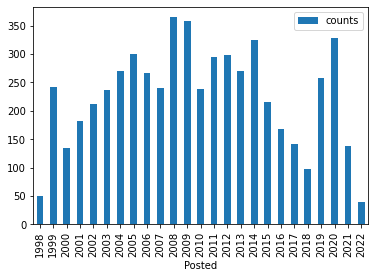

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('ufos_in_texas.csv')

df['Posted'] = pd.to_datetime(df.Posted)
df['Posted'] = df.Posted.dt.year
newdf = df.groupby('Posted').size().reset_index(name='counts')
newdf.plot(x= 'Posted', y = 'counts', kind = 'bar')

0.9417634252539913


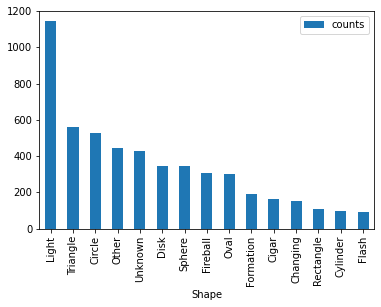

In [14]:
df = pd.read_csv('ufos_in_texas.csv')
df_grouped_shapes =  df.groupby('Shape').size().reset_index(name='counts')
df_grouped_shapes = df_grouped_shapes.sort_values(['counts'], ascending=False)
df_top_shapes = df_grouped_shapes[0:15]
percentage_of_data = df_top_shapes['counts'].sum()/df_grouped_shapes['counts'].sum()
print(percentage_of_data)
df_top_shapes.plot(x= 'Shape', y = 'counts', kind = 'bar')

Temporal analysis:

I considered the 'Posted' column and extracted the year information of all the reportings.
The trend of the number of reportings of UFOs on the site is going upwards from 1998 to 2008. This is followed by some variations in both directions.
Although there is no definite trend post 2008, the earlier uptrend could be attributed to the increasing number of users joining the internet with computers becoming easily available.
Shape analysis:

I grouped the reportings by shape and considered the top 16 most seen shapes for analysis. These correspond to 94% of the dataset.
The most reported shape is that of 'light'. Among the other shapes, 'Flash' can be considered similar to 'light'.
Among other shapes, 'circle', 'disk', 'sphere' can be considered as same shape.
In summary, people saw flashes of light or circular shaped formations in the sky and concluded that it is a UFO.